Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)
train_x's shape: (12288, 209)
test_x's shape: (12288, 50)
Cost after iteration 0: 0.6930497356599891
Cost after iteration 100: 0.6464320953428849
Cost after iteration 200: 0.6325140647912676
Cost after iteration 300: 0.6015024920354664
Cost after iteration 400: 0.5601966311605747
Cost after iteration 500: 0.5158304772764731
Cost after iteration 600: 0.47549013139433266
Cost after iteration 700: 0.43391631512257506
Cost after iteration 800: 0.4007977536203891
Cost after iteration 900: 0.35807050113237954
Cost after iteration 1000: 0.33942815383664077
Cost after iteration 1100: 0.3052753636196264
Cost after iteration 1200: 0.2749137728213018
Cost after iteration 1300: 0.2468176821061478
Cost after iteration 1400: 0.19850735037466086
Cost after iteration 1500: 0.1744831811255

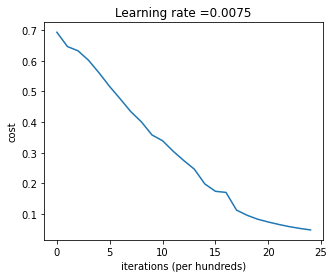

2021-07-23 22:48:07.036240
The final cost = 0.638358


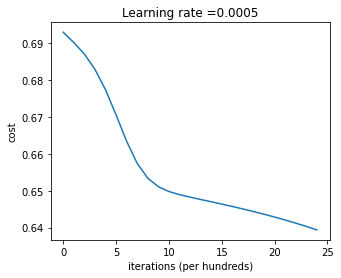

2021-07-23 22:48:50.248916
The final cost = 0.587800


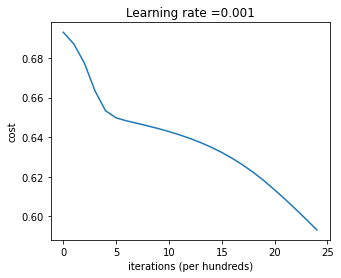

2021-07-23 22:49:32.485865
The final cost = 0.206029


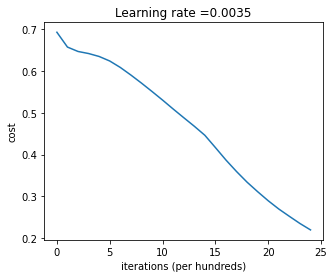

2021-07-23 22:50:14.801173
The final cost = 0.044215


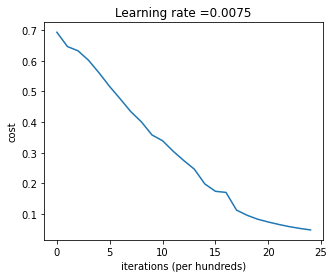

2021-07-23 22:50:59.065109


In [ ]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v2 import *
import datetime
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

##Dataset##
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

##Architecture of your model##

def initialize_parameters(n_x, n_h, n_y):
    np.random.seed(1)
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    
    assert((n_h, n_x) == W1.shape)
    assert((n_h, 1) == b1.shape)
    assert((n_y, n_h) == W2.shape)
    assert((n_y, 1) == b2.shape)
    
    parameters = {
        "W1": W1,
        "b1": b1,
        "W2": W2,
        "b2": b2
    }
    
    return parameters
    
    
def linear_activation_forward(A_prev, W, b, activation):
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
        
    assert(A.shape == (W.shape[0], A_prev.shape[1]))
    
    cache = (linear_cache, activation_cache)
    
    return A, cache
    
def compute_cost(AL, Y):
    m = Y.shape[1]
    
    cost = -(np.dot(np.log(AL), Y.T) + np.dot(np.log(1 - AL), (1 - Y).T)) / (1.0 * m)
    #print(cost.shape)
    cost = np.squeeze(cost)
    #print(cost.shape)
    #print(cost)
    assert(cost.shape == ( ))
    return cost


def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    return dA_prev, dW, db

def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2
    for i in range(1, L + 1):
        parameters["W" + str(i)] -= learning_rate * grads["dW" + str(i)]
        parameters["b" + str(i)] -= learning_rate * grads["db" + str(i)]
        
    return parameters

### CONSTANTS DEFINING THE MODEL ####
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

# GRADED FUNCTION: two_layer_model

def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1". Output: "A1, cache1, A2, cache2".
        A1, cache1 = linear_activation_forward(X, parameters["W1"], parameters["b1"], activation="relu")
        A2, cache2 = linear_activation_forward(A1, parameters["W2"], parameters["b2"], activation="sigmoid")
        
        # Compute cost
        cost = compute_cost(A2, Y)
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, activation="sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, activation="relu")
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0:
            costs.append(cost)
            
    if not(print_cost):
        print("The final cost = %f" %(cost))
       
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

def predict(X, y, parameters):
    m = X.shape[1]
    n = len(parameters) // 2
    p = np.zeros((1, m))
    
    probas, caches = L_model_forward(X, parameters)
    
    for i in range(probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0, i] = 1
        else:
            p[0, i] = 0
            
    print("Accuracy: " + str(np.sum(p == y) / (1.0 * m)))
    
    return p

parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)

print(datetime.datetime.now())
two_layer_model(train_x, train_y, layers_dims=(n_x, n_h, n_y), learning_rate=0.0005, num_iterations=2500, print_cost=False)
print(datetime.datetime.now())
two_layer_model(train_x, train_y, layers_dims=(n_x, n_h, n_y), learning_rate=0.0010, num_iterations=2500, print_cost=False)
print(datetime.datetime.now())
two_layer_model(train_x, train_y, layers_dims=(n_x, n_h, n_y), learning_rate=0.0035, num_iterations=2500, print_cost=False)
print(datetime.datetime.now())
two_layer_model(train_x, train_y, layers_dims=(n_x, n_h, n_y), learning_rate=0.0075, num_iterations=2500, print_cost=False)
print(datetime.datetime.now())
two_layer_model(train_x, train_y, layers_dims=(n_x, n_h, n_y), learning_rate=0.0150, num_iterations=2500, print_cost=False)
print(datetime.datetime.now())
two_layer_model(train_x, train_y, layers_dims=(n_x, n_h, n_y), learning_rate=0.0750, num_iterations=2500, print_cost=False)
print(datetime.datetime.now())
two_layer_model(train_x, train_y, layers_dims=(n_x, n_h, n_y), learning_rate=0.1500, num_iterations=2500, print_cost=False)
print(datetime.datetime.now())

predictions_train = predict(train_x, train_y, parameters)
predictions_test = predict(test_x, test_y, parameters)

def initialize_parameters_deep(layer_dims):
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)
    
    for i in range(1, L):
        #Be careful, the scaler is np.sqrt(layers_dims[i - 1]), not constant 0.01
        parameters['W' + str(i)] = np.random.randn(layer_dims[i], layer_dims[i - 1]) / np.sqrt(layers_dims[i - 1])
        parameters["b" + str(i)] = np.zeros((layer_dims[i], 1))
        
        assert((layer_dims[i], layer_dims[i - 1]) == parameters["W" + str(i)].shape)
        assert((layer_dims[i], 1) == parameters["b" + str(i)].shape)
        
    return parameters

def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2
    for i in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters["W" + str(i)], parameters["b" + str(i)], "relu")
        caches.append(cache)
        
    AL, cache = linear_activation_forward(A, parameters["W" + str(L)], parameters["b" + str(L)], "sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1, X.shape[1]))
    
    return AL, caches

def compute_cost(AL, Y):
    m = Y.shape[1]
    
    cost = -(np.dot(np.log(AL), Y.T) + np.dot(np.log(1 - AL), (1 - Y).T)) / (m * 1.0)
    #print(cost.shape)
    cost = np.squeeze(cost)
    #print(cost.shape)
    #print(cost)
    assert(cost.shape == ( ))
    return cost

def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[L - 1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation="sigmoid")
    
    for i in reversed(range(L - 1)):
        current_cache = caches[i]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(i + 2)], current_cache, activation="relu")
        grads["dA" + str(i + 1)] = dA_prev_temp
        grads["dW" + str(i + 1)] = dW_temp
        grads["db" + str(i + 1)] = db_temp
        
    return grads

def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2
    for i in range(1, L + 1):
        parameters["W" + str(i)] -= learning_rate * grads["dW" + str(i)]
        parameters["b" + str(i)] -= learning_rate * grads["db" + str(i)]
        
    return parameters

### CONSTANTS ###
layers_dims = [12288, 20, 7, 5, 1] #  5-layer model

# GRADED FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization.
    parameters = initialize_parameters_deep(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
    
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
 
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)
pred_train = predict(train_x, train_y, parameters)
pred_test = predict(test_x, test_y, parameters)